In [82]:
import cv2
import json
from matplotlib import pyplot as plt
import numpy as np
import os
import random

# import a lot of things from keras:
# sequential model
from keras.models import Sequential

# layers
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, RandomFlip, RandomRotation, RandomContrast, RandomBrightness

# loss function
from keras.metrics import categorical_crossentropy

# callback functions
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# convert data to categorial vector representation
from keras.utils import to_categorical

# nice progress bar for loading data
from tqdm.notebook import tqdm

# helper function for train/test split
from sklearn.model_selection import train_test_split

# import confusion matrix helper function
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# import pre-trained model
from keras.applications.vgg16 import VGG16

# include only those gestures
CONDITIONS = ['like', 'stop', 'dislike', 'rock', 'peace']

# image size
IMG_SIZE = 64
SIZE = (IMG_SIZE, IMG_SIZE)

# number of color channels we want to use
# set to 1 to convert to grayscale
# set to 3 to use color images
COLOR_CHANNELS = 3

PATH = '../gesture_dataset_sample'

In [83]:
annotations = dict()

for condition in CONDITIONS:
    with open(f'{PATH}/_annotations/{condition}.json') as f:
        annotations[condition] = json.load(f)

In [84]:
def preprocess_image(img):
    if COLOR_CHANNELS == 1:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(img, SIZE)
    return img_resized

In [85]:
  
images = [] # stores actual image data
labels = [] # stores labels (as integer - because this is what our network needs)
label_names = [] # maps label ints to their actual categories so we can understand predictions later

# loop over all conditions
# loop over all files in the condition's directory
# read the image and corresponding annotation
# crop image to the region of interest
# preprocess image
# store preprocessed image and label in corresponding lists
for condition in CONDITIONS:
    for filename in tqdm(os.listdir(f'{PATH}/{condition}')):
        # extract unique ID from file name
        UID = filename.split('.')[0]
        img = cv2.imread(f'{PATH}/{condition}/{filename}')
        
        # get annotation from the dict we loaded earlier
        try:
            annotation = annotations[condition][UID]
        except Exception as e:
            print(e)
            continue
        
        # iterate over all hands annotated in the image
        for i, bbox in enumerate(annotation['bboxes']):
            # annotated bounding boxes are in the range from 0 to 1
            # therefore we have to scale them to the image size
            x1 = int(bbox[0] * img.shape[1])
            y1 = int(bbox[1] * img.shape[0])
            w = int(bbox[2] * img.shape[1])
            h = int(bbox[3] * img.shape[0])
            x2 = x1 + w
            y2 = y1 + h
            
            # crop image to the bounding box and apply pre-processing
            crop = img[y1:y2, x1:x2]
            preprocessed = preprocess_image(crop)
            
            # get the annotated hand's label
            # if we have not seen this label yet, add it to the list of labels
            label = annotation['labels'][i]
            if label not in label_names:
                    label_names.append(label)
                
            label_index = label_names.index(label)
                
            images.append(preprocessed)
            labels.append(label_index)

  0%|          | 0/250 [00:00<?, ?it/s]

In [ ]:
# Load my own json file
with open('annot-jonas.json') as f:
    own_annotations = json.load(f)

Here im going through each condition and saving the images and labels

In [ ]:
  
own_images = [] # stores actual image data
own_labels = [] # stores labels (as integer - because this is what our network needs)
own_label_names = [] # maps label ints to their actual categories so we can understand predictions later

# loop over all conditions
# loop over all files in the condition's directory
# read the image and corresponding annotation
# crop image to the region of interest
# preprocess image
# store preprocessed image and label in corresponding lists
for condition in CONDITIONS:
    for filename in tqdm(os.listdir(f'./imgs/{condition}')):
        # extract unique ID from file name
        UID = filename.split('.')[0]
        img = cv2.imread(f'./imgs/{condition}/{filename}')
        # get annotation from the dict we loaded earlier
        try:
            annotation = own_annotations[UID]
        except Exception as e:
            print(e)
            print(f'Could not find annotation for {condition}/{UID}')
            continue
        
        # iterate over all hands annotated in the image
        for i, bbox in enumerate(annotation['bboxes']):
            # annotated bounding boxes are in the range from 0 to 1
            # therefore we have to scale them to the image size
            x1 = int(bbox[0] * img.shape[1])
            y1 = int(bbox[1] * img.shape[0])
            w = int(bbox[2] * img.shape[1])
            h = int(bbox[3] * img.shape[0])
            x2 = x1 + w
            y2 = y1 + h
            
            # crop image to the bounding box and apply pre-processing
            crop = img[y1:y2, x1:x2]
            preprocessed = preprocess_image(crop)
            
            # get the annotated hand's label
            # if we have not seen this label yet, add it to the list of labels
            label = annotation['labels'][i]
            if label not in own_label_names:
                    own_label_names.append(label)
                
            label_index = label_names.index(label)
                
            own_images.append(preprocessed)
            own_labels.append(label_index)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)


In [ ]:
X_train = np.array(X_train).astype('float32')
X_train = X_train / 255.

X_test = np.array(X_test).astype('float32')
X_test = X_test / 255.

y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

train_label = y_train_one_hot
test_label = y_test_one_hot

X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)
X_test = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)

Here im creating my own X_test and y_test for later predicitons

In [ ]:
own_X_test = np.array(own_images).astype('float32')
own_X_test = own_X_test / 255.

own_y_test_one_hot = to_categorical(own_labels)

own_y_test = own_labels

own_X_test = own_X_test.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)

In [ ]:
# variables for hyperparameters
batch_size = 8
epochs = 50
num_classes = len(label_names)
activation = 'relu'
activation_conv = 'leaky_relu'  # LeakyReLU
layer_count = 2
num_neurons = 64

# define model structure
# with keras, we can use a model's add() function to add layers to the network one by one
model = Sequential()

# data augmentation (this can also be done beforehand - but don't augment the test dataset!)
model.add(RandomFlip('horizontal'))
model.add(RandomContrast(0.1))
#model.add(RandomBrightness(0.1))
#model.add(RandomRotation(0.2))

# first, we add some convolution layers followed by max pooling
model.add(Conv2D(64, kernel_size=(9, 9), activation=activation_conv, input_shape=(SIZE[0], SIZE[1], COLOR_CHANNELS), padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4), padding='same'))

model.add(Conv2D(32, (5, 5), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3), padding='same'))

model.add(Conv2D(32, (3, 3), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# dropout layers can drop part of the data during each epoch - this prevents overfitting
model.add(Dropout(0.2))

# after the convolution layers, we have to flatten the data so it can be fed into fully connected layers
model.add(Flatten())

# add some fully connected layers ("Dense")
for i in range(layer_count - 1):
    model.add(Dense(num_neurons, activation=activation))

model.add(Dense(num_neurons, activation=activation))

# for classification, the last layer has to use the softmax activation function, which gives us probabilities for each category
model.add(Dense(num_classes, activation='softmax'))

# specify loss function, optimizer and evaluation metrics
# for classification, categorial crossentropy is used as a loss function
# use the adam optimizer unless you have a good reason not to
model.compile(loss=categorical_crossentropy, optimizer="adam", metrics=['accuracy'])

# define callback functions that react to the model's behavior during training
# in this example, we reduce the learning rate once we get stuck and early stopping
# to cancel the training if there are no improvements for a certain amount of epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
stop_early = EarlyStopping(monitor='val_loss', patience=3)

C:\Users\brede\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
history = model.fit(
    X_train,
    train_label,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, test_label),
    callbacks=[reduce_lr, stop_early]
)

Epoch 1/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.1854 - loss: 1.8055 - val_accuracy: 0.2607 - val_loss: 1.7750 - learning_rate: 0.0010
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.2124 - loss: 1.7749 - val_accuracy: 0.3620 - val_loss: 1.6320 - learning_rate: 0.0010
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.3874 - loss: 1.5412 - val_accuracy: 0.4755 - val_loss: 1.3378 - learning_rate: 0.0010
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.5121 - loss: 1.2253 - val_accuracy: 0.6871 - val_loss: 0.8679 - learning_rate: 0.0010
Epoch 5/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.6714 - loss: 0.9199 - val_accuracy: 0.7853 - val_loss: 0.6213 - learning_rate: 0.0010
Epoch 6/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.7390 - loss: 0.7273 - val_accuracy: 0.7546 - val_loss: 0.6341 - learning_rate: 0.0010
Epoch 7/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.8172 - loss: 0.

In [ ]:
model.save('gesture_recognition.keras')

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
before [[4.7735736e-13 9.4487217e-07 7.1498840e-10 9.9999905e-01 2.1456186e-09
  4.7013816e-11]
 [1.4164046e-15 1.2115208e-13 6.9602146e-19 3.2568559e-17 1.0000000e+00
  3.2535286e-09]
 [6.1503429e-06 9.9857211e-01 2.4586344e-08 1.4158740e-03 5.8340338e-06
  3.6406888e-08]
 ...
 [1.5237282e-05 3.1305687e-03 8.4957799e-05 9.9465179e-01 7.0182199e-04
  1.4156415e-03]
 [6.6226577e-12 3.8127982e-06 2.9308660e-08 9.9999607e-01 4.9209692e-08
  9.4570213e-11]
 [5.5459885e-05 2.3511071e-02 9.5049309e-06 1.0058599e-03 9.7077608e-01
  4.6421317e-03]]
probabilities [3 4 1 5 0 4 3 3 1 1 1 2 1 1 5 3 1 2 0 2 0 1 5 3 4 0 0 1 5 0 5 1 5 1 0 4 0
 5 0 3 2 1 4 0 3 2 4 5 4 5 3 3 1 1 5 3 1 4 0 0 2 5 4 5 4 1 4 2 1 2 1 3 1 1
 1 1 3 5 5 2 5 1 0 5 1 2 4 0 4 0 1 2 2 2 5 1 1 3 1 2 5 2 2 4 3 0 4 4 1 5 2
 2 1 4 1 4 2 2 1 2 4 2 4 2 0 1 1 2 3 1 5 5 3 0 0 1 1 0 1 3 3 0 0 0 2 4 4 1
 5 2 0 2 1 3 2 3 2 4 4 5 4 1 2 2 1 0 1 1 3 2 4 4 2 3 4 2 1 1 2 4 1 1 4 2 4
 3 4 5 4 1 1 1 5 4 2 2 3

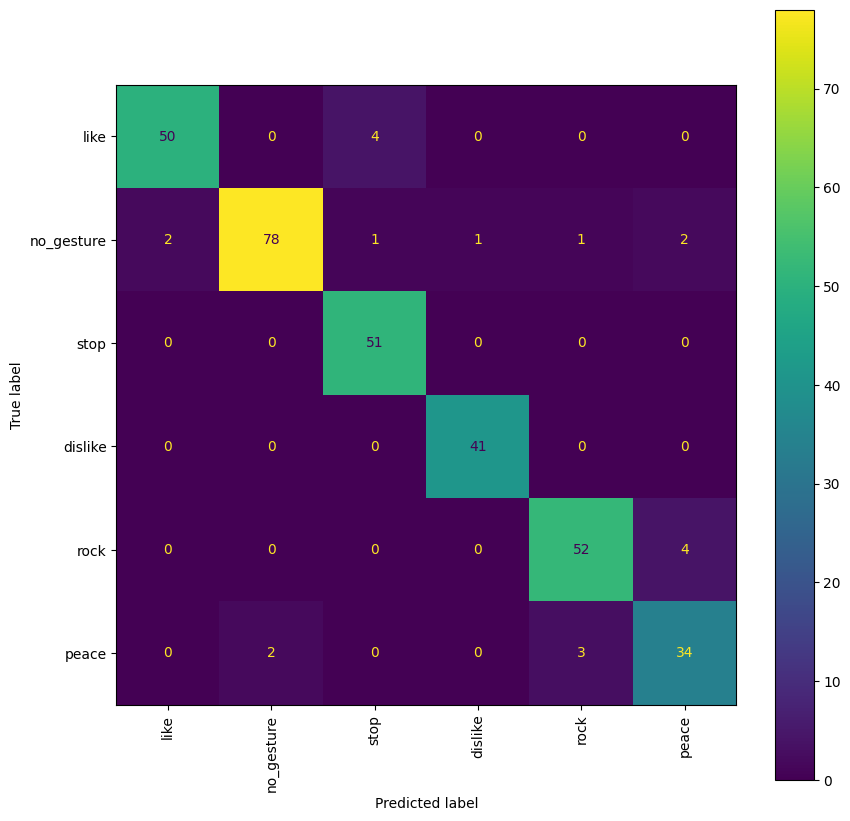

In [ ]:
# let the model make predictions for our training data
y_predictions = model.predict(X_test)

# we get a 2D numpy array with probabilities for each category
print('before', y_predictions)

# to build a confusion matrix, we have to convert it to classifications
# this can be done by using the argmax() function to set the probability to 1 and the rest to 0
y_predictions = np.argmax(y_predictions, axis=1)

print('probabilities', y_predictions)

# create and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_predictions)

fig = plt.figure(figsize=(10, 10))

ConfusionMatrixDisplay(conf_matrix, display_labels=label_names).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
pass

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
before [[9.99762118e-01 1.14340246e-05 4.77370450e-05 1.31587707e-09
  1.56517842e-07 1.78548580e-04]
 [9.56517398e-01 5.87318372e-03 3.70275676e-02 3.04640344e-05
  3.38821774e-05 5.17451903e-04]
 [9.99999642e-01 3.61162819e-07 8.12283840e-09 1.19419342e-15
  1.07086848e-11 2.97085396e-08]
 [8.14114755e-04 7.63953617e-03 9.41184044e-01 2.23865174e-02
  3.25152976e-03 2.47242153e-02]
 [6.32011890e-03 7.84751832e-01 1.92618415e-01 1.32746072e-02
  2.73823645e-03 2.96759070e-04]
 [4.60919254e-02 9.41017807e-01 1.04076015e-02 5.88484516e-04
  1.22313201e-03 6.71078684e-04]
 [1.04430057e-07 3.99245997e-04 2.88152078e-05 9.99321938e-01
  3.03028150e-06 2.46913842e-04]
 [2.10959348e-03 5.71060218e-02 1.40862800e-02 9.14918840e-01
  2.39322614e-03 9.38603282e-03]
 [3.64629636e-06 6.79874700e-03 1.28181942e-03 9.84464943e-01
  5.55671693e-04 6.89526601e-03]
 [8.32036130e-06 7.39981033e-06 6.91632522e-06 2.22181640e-07
  9.70102668e-01 2.98743974e-02]
 [2.0

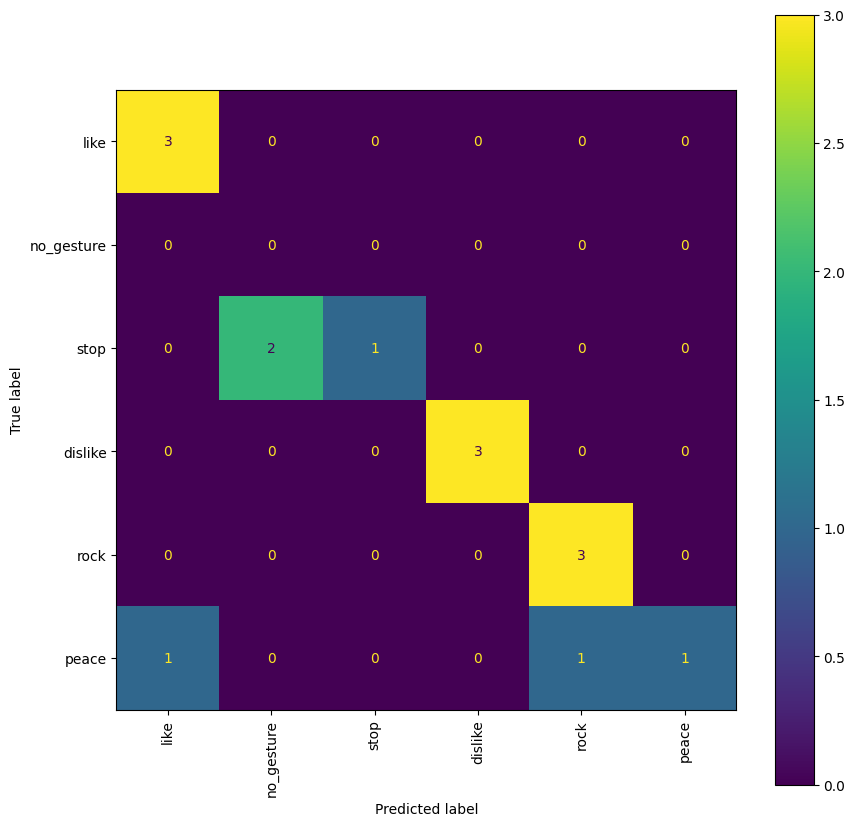

In [ ]:
# let the model make predictions using our own data
y_predictions = model.predict(own_X_test)

# we get a 2D numpy array with probabilities for each category
print('before', y_predictions)

# to build a confusion matrix, we have to convert it to classifications
# this can be done by using the argmax() function to set the probability to 1 and the rest to 0
y_predictions = np.argmax(y_predictions, axis=1)

print('probabilities', y_predictions)

# create and plot confusion matrix
conf_matrix = confusion_matrix(own_y_test, y_predictions)

fig = plt.figure(figsize=(10, 10))

ConfusionMatrixDisplay(conf_matrix, display_labels=label_names).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
pass